<a href="https://colab.research.google.com/github/frank-morales2020/Cloud_curious/blob/master/mistral_finetunning_squad2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [1]:
# Install Pytorch & other libraries
!pip install torch tensorboard --quiet

# Install Hugging Face libraries
!pip install  --upgrade transformers datasets accelerate evaluate bitsandbytes --quiet

#FlashAttention only supports Ampere GPUs or newer. #NEED A100 IN GOOGLE COLAB
#!pip install -U transformers
# Uncomment only if you're using A100 GPU
!pip install -U flash-attn --no-build-isolation --quiet


! pip install peft --quiet
! pip install datasets trl ninja packaging --quiet

!pip install diffusers safetensors  --quiet
!pip install colab-env --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googl

In [2]:
!nvidia-smi

Tue Jun  4 20:27:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   45C    P8              17W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
#load all libraries
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import AdamW
#from transformers import BertModel, BertTokenizerFast, AdamW
# AutoTokenizer, AutoModelForQuestionAnswering, BertTokenizer, BertForQuestionAnswering
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

In [ ]:
#MODEL_PATH = "bert-base-uncased"

## Load Dataset

In [4]:
#get SQuAD v2
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2024-06-04 20:27:47--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M  --.-KB/s    in 0.09s   

2024-06-04 20:27:47 (450 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2024-06-04 20:27:47--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       1

In [5]:
num_questions = 0
num_posible = 0
num_imposible = 0

In [6]:
#note: below code will only return questions wich have answers (i.e. not the ones flagged as imposible to answer)
def get_data(path):
    #read each file and retrieve the contexts, qustions and answers
  with open(path, 'rb') as f:
    raw_data = json.load(f)

  contexts = []
  questions = []
  answers = []
  num_q = 0
  num_pos = 0
  num_imp = 0

  for group in raw_data['data']:
    for paragraph in group['paragraphs']:
      context = paragraph['context']
      for qa in paragraph['qas']:
        question = qa['question']
        num_q  = num_q  +1
        if qa['is_impossible'] == True:
            num_imp = num_imp +1
        else:
            num_pos = num_pos +1
        for answer in qa['answers']:
          contexts.append(context.lower())
          questions.append(question.lower())
          answers.append(answer)

  return num_q, num_pos, num_imp, contexts, questions, answers

In [7]:
import json
num_q, num_pos, num_imp, train_contexts, train_questions, train_answers = get_data('train-v2.0.json')
num_questions  = num_q
num_posible = num_pos
num_imposible  = num_imp


In [30]:
len(train_answers)

86821

In [10]:
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}
#{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "Oh, just some guy named William Shakespeare. Ever heard of him?"}]}
#{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "Around 384,400 kilometers. Give or take a few, like that really matters."}]}

{'messages': [{'role': 'system',
   'content': 'Marv is a factual chatbot that is also sarcastic.'},
  {'role': 'user', 'content': "What's the capital of France?"},
  {'role': 'assistant',
   'content': "Paris, as if everyone doesn't know that already."}]}

In [21]:
n=100
print(train_questions[n])

how many weeks did their single "independent women part i" stay on top?


In [19]:
print(train_answers[n]['text'])

Dangerously in Love


In [ ]:
for n in range(100):
    print(n)

In [41]:
for n in range(1000):
    #m={"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": train_questions[n]}, {"role": "assistant", "content": train_answers[n]['text']}]}
    #m={"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris", "weight": 0}, {"role": "user", "content": "Can you be more sarcastic?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already.", "weight": 1}]}
    m={"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": train_questions[n]}, {"role": "assistant", "content": train_answers[n]['text'], "weight": 0}, {"role": "user", "content": "Can you be more sarcastic?"}, {"role": "assistant", "content": "%s, as if everyone doesn't know that already."%train_answers[n]['text'], "weight": 1}]}
    m = json.dumps(m)
    print(m)

{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "when did beyonce start becoming popular?"}, {"role": "assistant", "content": "in the late 1990s", "weight": 0}, {"role": "user", "content": "Can you be more sarcastic?"}, {"role": "assistant", "content": "in the late 1990s, as if everyone doesn't know that already.", "weight": 1}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "what areas did beyonce compete in when she was growing up?"}, {"role": "assistant", "content": "singing and dancing", "weight": 0}, {"role": "user", "content": "Can you be more sarcastic?"}, {"role": "assistant", "content": "singing and dancing, as if everyone doesn't know that already.", "weight": 1}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "when did beyonce leave destiny'

In [39]:
print(m)

{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "what role did beyonc\u00e9 have in destiny's child?"}, {"role": "assistant", "content": "lead singer", "weight": 0}, {"role": "user", "content": "Can you be more sarcastic?"}, {"role": "assistant", "content": "lead singer, as if everyone doesn't know that already.", "weight": 1}]}


In [8]:
print(train_questions[0:10])
print(train_answers[0:10])

['when did beyonce start becoming popular?', 'what areas did beyonce compete in when she was growing up?', "when did beyonce leave destiny's child and become a solo singer?", 'in what city and state did beyonce  grow up? ', 'in which decade did beyonce become famous?', 'in what r&b group was she the lead singer?', 'what album made her a worldwide known artist?', "who managed the destiny's child group?", 'when did beyoncé rise to fame?', "what role did beyoncé have in destiny's child?"]
[{'text': 'in the late 1990s', 'answer_start': 269}, {'text': 'singing and dancing', 'answer_start': 207}, {'text': '2003', 'answer_start': 526}, {'text': 'Houston, Texas', 'answer_start': 166}, {'text': 'late 1990s', 'answer_start': 276}, {'text': "Destiny's Child", 'answer_start': 320}, {'text': 'Dangerously in Love', 'answer_start': 505}, {'text': 'Mathew Knowles', 'answer_start': 360}, {'text': 'late 1990s', 'answer_start': 276}, {'text': 'lead singer', 'answer_start': 290}]


In [ ]:
num_q, num_pos, num_imp, valid_contexts, valid_questions, valid_answers = get_data('dev-v2.0.json')
num_questions  = num_questions + num_q
num_posible = num_posible + num_pos
num_imposible = num_imposible  + num_imp

print(f"Total number of questions: {num_questions}")
print(f"Total number of Answerable questions: {num_posible}")
print(f"Total number of impossible questions: {num_imposible}")

Total number of questions: 142192
Total number of Answerable questions: 92749
Total number of impossible questions: 49443


In [ ]:
print(valid_questions[0:10])
print(valid_answers[0:10])

['in what country is normandy located?', 'in what country is normandy located?', 'in what country is normandy located?', 'in what country is normandy located?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'when were the normans in normandy?', 'from which countries did the norse originate?', 'from which countries did the norse originate?']
[{'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': 'France', 'answer_start': 159}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': 'in the 10th and 11th centuries', 'answer_start': 87}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': '10th and 11th centuries', 'answer_start': 94}, {'text': 'Denmark, Iceland and Norway', 'answer_start': 256}, {'text': 'Denmark, Iceland and Norway', 'answer_start': 256}]


In [ ]:
def add_answer_end(answers, contexts):
  for answer, context in zip(answers, contexts):
    answer['text'] = answer['text'].lower()
    answer['answer_end'] = answer['answer_start'] + len(answer['text'])

add_answer_end(train_answers, train_contexts)
add_answer_end(valid_answers, valid_contexts)

In [ ]:
print(f"Context: {train_contexts[0]}")
print(f"Question: {train_questions[0]}")
print(f"Answer: {train_answers[0]}")

Context: beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ bee-yon-say) (born september 4, 1981) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r&b girl-group destiny's child. managed by her father, mathew knowles, the group became one of the world's best-selling girl groups of all time. their hiatus saw the release of beyoncé's debut album, dangerously in love (2003), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number-one singles "crazy in love" and "baby boy".
Question: when did beyonce start becoming popular?
Answer: {'text': 'in the late 1990s', 'answer_start': 269, 'answer_end': 286}


In [ ]:
test_rec = 30
print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Answer: {valid_answers[test_rec]}")

Context: the english name "normans" comes from the french words normans/normanz, plural of normant, modern french normand, which is itself borrowed from old low franconian nortmann "northman" or directly from old norse norðmaðr, latinized variously as nortmannus, normannus, or nordmannus (recorded in medieval latin, 9th century) to mean "norseman, viking".
Question: what is the original meaning of the word norman?
Answer: {'text': 'norseman, viking', 'answer_start': 331, 'answer_end': 347}


## Tokenize

### Find max lengths

653


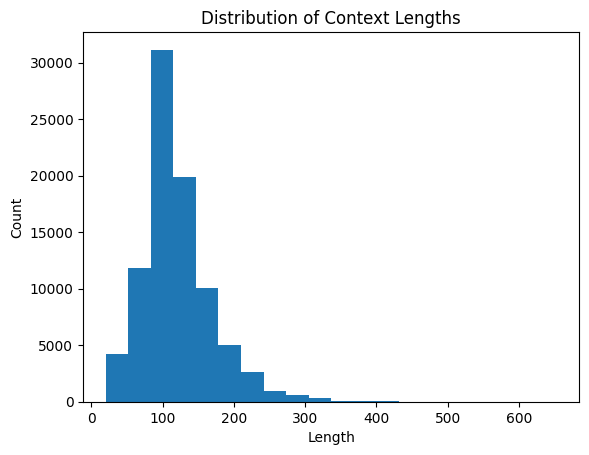

In [ ]:
import matplotlib.pyplot as plt
#Text lengths to contextx
token_lens = []

for txt in train_contexts:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens.append(len(txt.split(' ')))


print(max(token_lens))

plt.hist(token_lens,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

40
86821


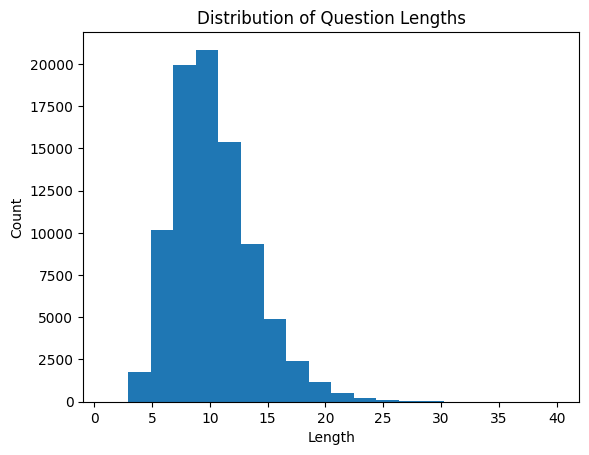

In [ ]:
#Test lengths of Questions
token_lens2 = []

for txt in train_questions:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

In [ ]:
MAX_LENGTH = 250

### tokenize

In [ ]:
#!pip install trl --quiet
#!pip install accelerate --quiet

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from trl import setup_chat_format

# Hugging Face model id
model_id = "mistralai/Mistral-7B-Instruct-v0.1" #01 march 2024
#model_id = "mistralai/Mixtral-8x7B-Instruct-v0.1" # 04/03/2024

#model_id = "abacusai/Smaug-72B-v0.1" #04 march 2024
#model_id = "codellama/CodeLlama-7b-hf"

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    #attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
tokenizerFast = AutoTokenizer.from_pretrained(model_id,use_fast=True)
tokenizerFast.padding_side = 'right' # to prevent warnings

# We redefine the pad_token and pad_token_id with out of vocabulary token (unk_token)
tokenizerFast.pad_token = tokenizerFast.unk_token
tokenizerFast.pad_token_id = tokenizerFast.unk_token_id

# # set chat template to OAI chatML, remove if you start from a fine-tuned model
model, tokenizerFast = setup_chat_format(model, tokenizerFast)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
#tokenizerFast = BertTokenizerFast.from_pretrained(MODEL_PATH)

train_encodings_fast = tokenizerFast(train_questions, train_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)
valid_encodings_fast = tokenizerFast(valid_questions, valid_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)


In [ ]:
type(train_encodings_fast)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:

print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['input_ids'][0]))

dict_keys(['input_ids', 'attention_mask'])
dict_keys(['input_ids', 'attention_mask'])
86821
250


In [ ]:
print(train_encodings_fast['input_ids'][0])

[1, 739, 863, 347, 28724, 11069, 1149, 7888, 4387, 28804, 1, 347, 28724, 266, 22034, 319, 278, 3222, 873, 867, 28733, 28717, 4136, 325, 28748, 6309, 29240, 29097, 28768, 31099, 28711, 331, 29603, 28748, 347, 28706, 28733, 28724, 266, 28733, 21205, 28731, 325, 6363, 25494, 28705, 28781, 28725, 28705, 28740, 28774, 28783, 28740, 28731, 349, 396, 21419, 15307, 28725, 4034, 11660, 28725, 2395, 13876, 304, 18334, 28723, 5381, 304, 6333, 297, 295, 280, 6549, 28725, 22309, 293, 28725, 630, 7885, 297, 4118, 14493, 304, 17319, 3440, 2065, 390, 264, 1502, 28725, 304, 8536, 298, 24665, 297, 272, 3909, 28705, 28740, 28774, 28774, 28734, 28713, 390, 1736, 15307, 302, 408, 28800, 28726, 2746, 28733, 3063, 2620, 4279, 28742, 28713, 1502, 28723, 6900, 486, 559, 3140, 28725, 1610, 10345, 873, 867, 28725, 272, 2071, 3246, 624, 302, 272, 1526, 28742, 28713, 1489, 28733, 24943, 2746, 4938, 302, 544, 727, 28723, 652, 12014, 1589, 2672, 272, 5614, 302, 347, 28724, 266, 22034, 28742, 28713, 9928, 4708, 28725

In [ ]:
type(train_answers[0]['text'])
train_answers[0].keys()

dict_keys(['text', 'answer_start', 'answer_end'])

In [ ]:
train_answer_encodings_fast = tokenizerFast(train_answers[0]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)


In [ ]:
def ret_Answer_start_and_end_train(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(train_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encodings_fast['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            #print(len(answer_encoding_fast['input_ids']))
            #print(answer_encoding_fast[i])
            if (answer_encoding_fast['input_ids'][i] != train_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            if 'i' in locals():
                #print(i)
                i=i
            else:
                i=0

            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)


In [ ]:
test_rec=92

z,x = ret_Answer_start_and_end_train(test_rec)
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

0 0

split with luckett and rober
<s> what event caused beyonce's depression?<s> letoya luckett and roberson became unhappy with mathew's managing of the band and eventually were replaced by farrah franklin and michelle williams. beyoncé experienced depression following the split with luckett and roberson after being publicly blamed by the media, critics, and blogs for its cause. her long-standing boyfriend left her at this time. the depression was so severe it lasted for a couple of years, during which she occasionally kept herself in her bedroom for days and refused to eat anything. beyoncé stated that she struggled to speak about her depression because destiny's child had just won their first grammy award and she feared no one would take her seriously. beyoncé would later speak of her mother as the person who helped her fight it. franklin was dismissed, leaving just beyoncé, rowland, and williams.<|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_en

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'attention_mask'])
dict_keys(['input_ids', 'attention_mask'])
86821


In [ ]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings_fast['input_ids'])):
    #print(h)
    s, e = ret_Answer_start_and_end_train(h)
    #print(s,e)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


train_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

5127


In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'attention_mask'])
86821


In [ ]:
test_rec = 1
print(train_encodings_fast['start_positions'][test_rec])
print(train_encodings_fast['end_positions'][test_rec])
predict_answer_tokens = train_encodings_fast.input_ids[test_rec][train_encodings_fast['start_positions'][test_rec] : train_encodings_fast['end_positions'][test_rec]]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

87
89
singing and
singing and dancing
<s> what areas did beyonce compete in when she was growing up?<s> beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ bee-yon-say) (born september 4, 1981) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r&b girl-group destiny's child. managed by her father, mathew knowles, the group became one of the world's best-selling girl groups of all time. their hiatus saw the release of beyoncé's debut album, dangerously in love (2003), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number-one singles "crazy in love" and "baby boy".<|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|

In [ ]:
def ret_Answer_start_and_end_valid(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(valid_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(valid_encodings_fast['input_ids'][idx])  -  len(answer_encoding_fast['input_ids'])   ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != valid_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            if 'i' in locals():
                #print(i)
                i=i
            else:
                i=0
            #i=0
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [ ]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(valid_encodings_fast['input_ids']) ):
    #print(h)
    s, e = ret_Answer_start_and_end_valid(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


valid_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

1138


In [ ]:
test_rec=2

z,x = ret_Answer_start_and_end_valid(test_rec)

predict_answer_tokens = valid_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(valid_answers[test_rec]['text'])
print(tokenizerFast.decode(valid_encodings_fast['input_ids'][test_rec]))

fr
france
<s> in what country is normandy located?<s> the normans (norman: nourmands; french: normands; latin: normanni) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ("norman" comes from "norseman") raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman-gaulish populations, their descendants would gradually merge with the carolingian-based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.<|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im

In [ ]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['start_positions']))
print(len(train_encodings_fast['end_positions']))
print(len(valid_encodings_fast['input_ids']))
print(len(valid_encodings_fast['start_positions']))
print(len(valid_encodings_fast['end_positions']))

dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])
86821
86821
86821
20302
20302
20302


In [ ]:
#tokenizerFast.decode(train_encodings_fast['input_ids'][0])

In [ ]:
tokenizerFast.decode(train_encodings_fast['input_ids'][0])

'<s> when did beyonce start becoming popular?<s> beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ bee-yon-say) (born september 4, 1981) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r&b girl-group destiny\'s child. managed by her father, mathew knowles, the group became one of the world\'s best-selling girl groups of all time. their hiatus saw the release of beyoncé\'s debut album, dangerously in love (2003), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number-one singles "crazy in love" and "baby boy".<|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im

In [ ]:
test_row= 0
print(train_contexts[test_row][train_answers[test_row]['answer_start']:train_answers[test_row]['answer_end']])

in the late 1990s


In [ ]:

answer_start_index = 75
answer_end_index = 79

predict_answer_tokens = train_encodings_fast.input_ids[0][answer_start_index : answer_end_index]
tokenizerFast.decode(predict_answer_tokens)

'texas, she'

## OPTIONAL: try a pretrained model. (uncomment to test out)

In [ ]:
#tokenizer2 = BertTokenizer.from_pretrained("deepset/bert-base-cased-squad2")
#model2 = BertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2")

In [ ]:
#question= train_questions[0]
#text = train_contexts[0]

#print(question)
#print(text)


In [ ]:
#inputs = tokenizer2(question, text, return_tensors="pt")
#with torch.no_grad():
#    outputs = model2(**inputs)

In [ ]:
#answer_start_index = outputs.start_logits.argmax()
#answer_end_index = outputs.end_logits.argmax()
#print(answer_start_index)
#print(answer_end_index)



In [ ]:
#predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
#tokenizer2.decode(predict_answer_tokens)

## Create Dataset and Dataloaders

In [ ]:
class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            #'token_type_ids': torch.tensor(self.encodings['token_type_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
train_dataset = InputDataset(train_encodings_fast)
valid_dataset = InputDataset(valid_encodings_fast)

In [ ]:
print(len(train_dataset))
print(train_dataset.encodings.keys())
print(valid_dataset.encodings.keys())
#print(train_dataset)
#print(train_dataset[0].keys())

86821
dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])


In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=32)

In [ ]:

print(train_data_loader)

for batch in train_data_loader:
    print(batch)
    break

{'input_ids': tensor([[    1,   767,   905,  ..., 32001, 32001, 32001],
        [    1,   910,  1287,  ..., 32001, 32001, 32001],
        [    1,   767, 20337,  ..., 32001, 32001, 32001],
        ...,
        [    1,   767,   863,  ..., 32001, 32001, 32001],
        [    1,   272,   931,  ..., 32001, 32001, 32001],
        [    1,   767,   349,  ..., 32001, 32001, 32001]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([ 37,  48,  14,  12,  36,  80,  21, 119,  42, 158,  61,  33,   1,  71,
         91, 183]), 'end_positions': tensor([ 38,  56,  16,  17,  38,  82,  22, 120,  46, 166,  62,  42,   1,  81,
        108, 193])}


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Create Loss Functions

In [ ]:
# my function to manually calculate Cross Entropy Loss
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)/2
    return total_loss

In [ ]:
# my focal loss function. Focal Loss = (True Vector)*((1 - probs)^Gamma)*log(probs)
# where Gamma is a factor we use. setting Gamma = 0 makes this a Cross Entropy Loss function

def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):

    #calculate Probabilities by applying Softmax to the Start and End Logits. Then get 1 - probabilities
    smax = nn.Softmax(dim=1)
    probs_start = smax(start_logits)
    inv_probs_start = 1 - probs_start
    probs_end = smax(end_logits)
    inv_probs_end = 1 - probs_end

    #get log of probabilities. Note: NLLLoss required log probabilities. This is the Natural Log (Log base e)
    lsmax = nn.LogSoftmax(dim=1)
    log_probs_start = lsmax(start_logits)
    log_probs_end = lsmax(end_logits)

    nll = nn.NLLLoss()

    fl_start = nll(torch.pow(inv_probs_start, gamma)* log_probs_start, start_positions)
    fl_end = nll(torch.pow(inv_probs_end, gamma)*log_probs_end, end_positions)

    #return mean of the Loss for the start and end logits
    return ((fl_start + fl_end)/2)

### OPTIONAL: Uncomment this code if you want to test on one input .....

In [ ]:
#data = next(iter(train_data_loader))
#data.keys()

In [ ]:
#print(data['input_ids'].shape)
#print(data['attention_mask'].shape)

In [ ]:
#run one row
#model.to(device)
#model.train()
#input_ids = data['input_ids'][0].unsqueeze(0).to(device)
#attention_mask = data['attention_mask'][0].unsqueeze(0).to(device)
#start_positions = data['start_positions'][0].unsqueeze(0).to(device)
#end_positions = data['end_positions'][0].unsqueeze(0).to(device)

In [ ]:
#out_start, out_end = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

In [ ]:
#print(f"start logits shape: {out_start.shape}")
#print(f"end logits shape: {out_end.shape}")

In [ ]:
#answer_start_index = out_start.argmax()
#answer_end_index = out_end.argmax()
#print(answer_start_index)
#print(answer_end_index)

## Train Loop

In [ ]:
optim = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)
scheduler = ExponentialLR(optim, gamma=0.9)
total_acc = []
total_loss = []

In [ ]:
def train_epoch(model, dataloader, epoch):
    model = model.train()
    losses = []
    acc = []
    ctr = 0
    batch_tracker = 0
    for batch in tqdm(dataloader, desc = 'Running Epoch '):
        #batch.to
        #dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])
        #print(batch.keys['input_ids'])
        print(batch)
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask)
                #token_type_ids=token_type_ids)
        #loss = loss_fn(out_start, out_end, start_positions, end_positions)  # <---BASELINE.  Cross Entropy Loss is returned by Default
        loss = focal_loss_fn(out_start, out_end, start_positions, end_positions,1) #using gamma = 1
        losses.append(loss.item())
        loss.backward()
        optim.step()

        start_pred = torch.argmax(out_start, dim=1)
        end_pred = torch.argmax(out_end, dim=1)

        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())
        #ctr = ctr +1
        #if ctr==50:
        #    break
        batch_tracker = batch_tracker + 1
        if batch_tracker==250 and epoch==1:
            total_acc.append(sum(acc)/len(acc))
            loss_avg = sum(losses)/len(losses)
            total_loss.append(loss_avg)
            batch_tracker = 0
    scheduler.step()
    ret_acc = sum(acc)/len(acc)
    ret_loss = sum(losses)/len(losses)
    return(ret_acc, ret_loss)

In [ ]:
def eval_model(model, dataloader):
    model = model.eval()
    losses = []
    acc = []
    ctr = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc = 'Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            #token_type_ids = batch['token_type_ids'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)

            out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask)
                #token_type_ids=token_type_ids)

            start_pred = torch.argmax(out_start, dim=1)
            end_pred = torch.argmax(out_end, dim=1)

            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
            #ctr = ctr +1
            #if ctr==50:
            #    break
        ret_acc = sum(acc)/len(acc)
        ret_loss = 0
        #ret_loss = sum(losses)/len(losses)
    return(ret_acc)

In [ ]:
EPOCHS = 4

#model.to(device)
#print(train_data_loader)
for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_data_loader, epoch+1)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    val_acc = eval_model(model, valid_data_loader)
    print(f"Validation Accuracy: {val_acc}")

#val_acc, val_loss = eval_model(model, valid_data_loader)
#print(f"Validation Accuracy: {val_acc}   Validation Loss: {val_loss}")


In [ ]:
scheduler.get_last_lr()

In [ ]:
# plot Accuracy
plt.plot(total_acc, color='blue')
plt.ylabel('Accuracy')
plt.xlabel('Runs->')
plt.title("Total Train Accuracy over time");

In [ ]:
# plot Loss
plt.plot(total_loss, color='red')
plt.ylabel('Loss')
plt.xlabel('Runs->')
plt.title("Total Train Loss over time");

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/best_model_state.bin')

## Test

In [ ]:
def get_answer(question, context):
    inputs = tokenizerFast.encode_plus(question, context, return_tensors='pt').to(device)
    with torch.no_grad():
        output_start, output_end = model(**inputs)

        answer_start = torch.argmax(output_start)
        answer_end = torch.argmax(output_end)

        answer = tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

        return(answer)

In [ ]:
#device =
test_rec = 0

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
test_rec = 15

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
test_rec = 28

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
test_rec = 2000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
test_rec = 4000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")